In [ ]:
%matplotlib inline

Este notebook foi baseado em [Chad Fulton GitHub](https://github.com/ChadFulton/fulton_statsmodels_2017).

# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(33) # Garantindo reproducibilidade

# Classe `sm.tsa.statespace.MLEModel`

Existem 3 métodos em particular que devem ser analisados com cuidado: 

- `update`: Aceita parâmetros do modelo, ex: o parametros regresssor $\phi$ do modelo ARMA, e então atualiza as matrizes do sistema com estes parâmetros; 

- `loglike`: Executa as recursões do filtro de Kalman e retorna o valor da probabilidade conjunta da amostra;

- `filter`: Executa as recursões do filtro de Kalman e retorna um objeto com todos os elementos resultantes das recursões do filtro assim como a representação do modelo em espaço e estados;

- `smooth`: Executa as recursões do filtro de Kalman e o refinamento. Retorna um objeto com todos os elementos resultantes das recursões do filtro/refinamento assim como a representação do modelo em espaço e estados; 

- `simulation_smoother`: Cria um novo objeto que pode ser utilizado para criar um número arbitrário de estados e distúrbios simulados.

Além disso, vamos visitar a [documentação](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEModel.html) desta classe para futuras referências

# Nível do rio Nilo - Local level


## Dados

Os dados são utilizados são referentes ao volumo do rio Nilo no período de 1871 a 1970.

In [17]:
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')  
# Frequency http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

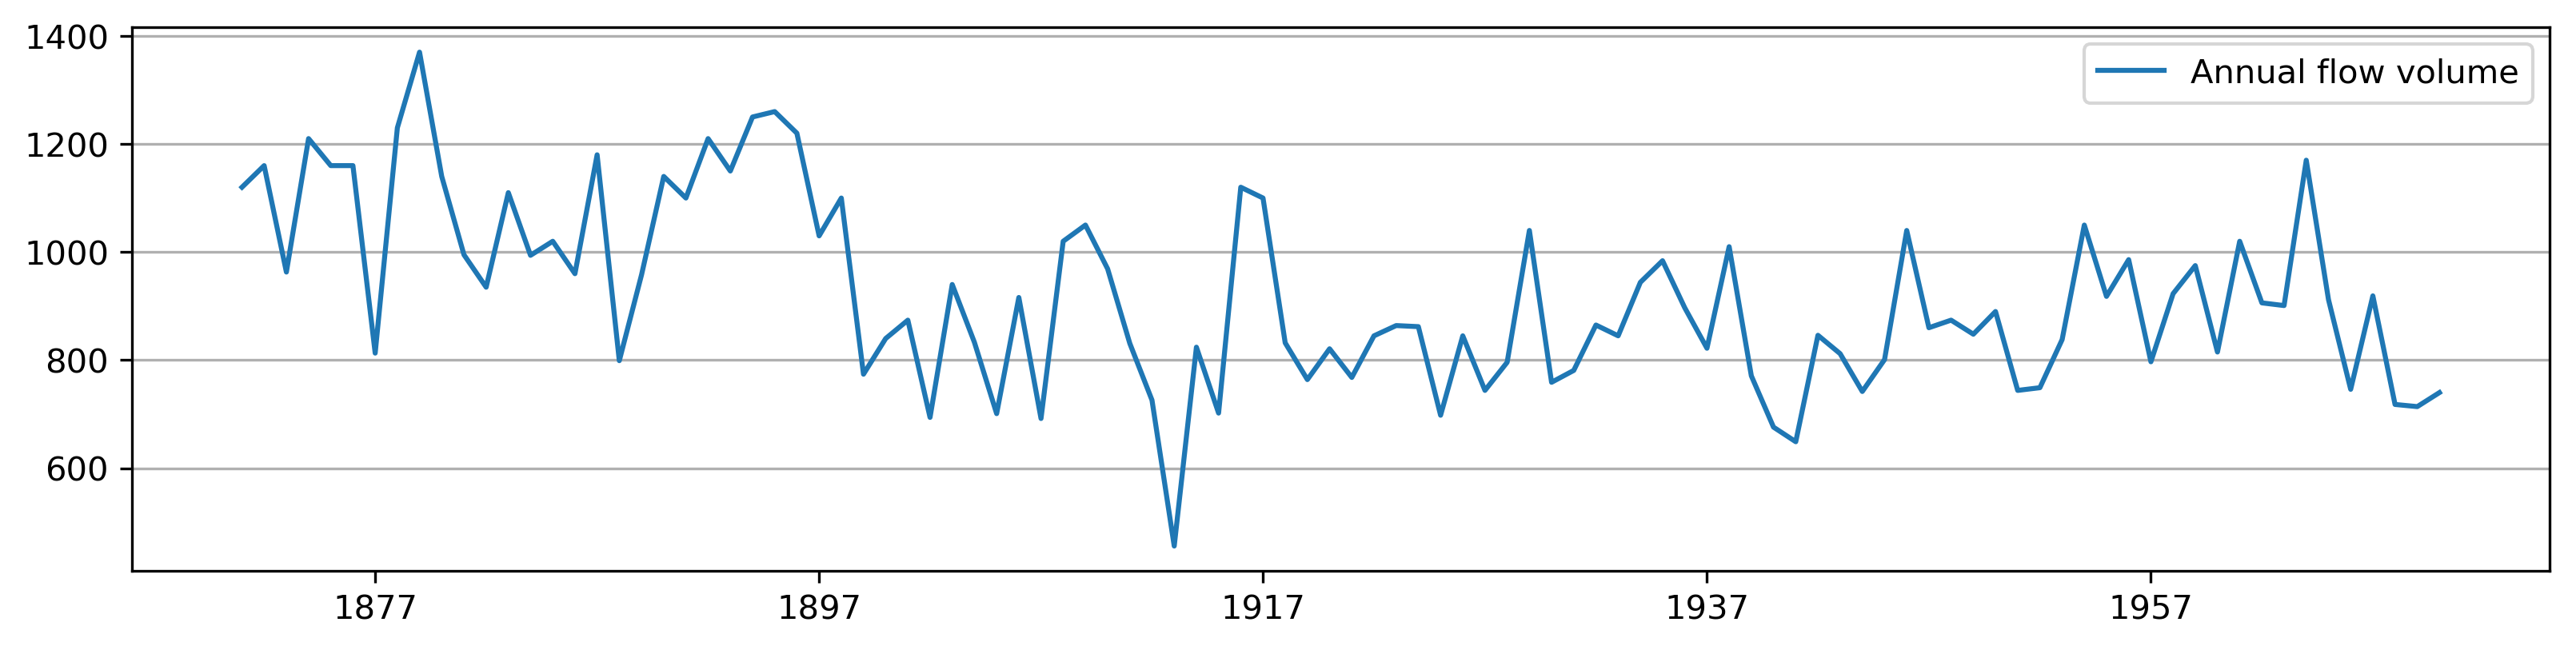

In [18]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

In [48]:
nile.head(2)

1871-01-01    1120.0
1872-01-01    1160.0
Freq: AS-JAN, Name: volume, dtype: float64

In [49]:
nile.shape

(100,)

## Modelo em espaço e estados

O modelo Local level: 

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
    \mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align}
$$



In [236]:
class LocalLevel(sm.tsa.statespace.MLEModel):
    
    # Definindo os parâmetros iniciais Epslion e Eta; 
    start_params = [1.0, 1.0]
    
    
    # Construtor da classe.
    # Observe que a variável endog (y_t) é requerida
    def __init__(self, endog):
        super(LocalLevel, self).__init__(endog, k_states=1)
        self['design', 0, 0] = 1.0      # Elemento Matriz Z_t
        self['transition', 0, 0] = 1.0  # Elemento Matriz T_t
        self['selection', 0, 0] = 1.0   # Elemento Matriz R_t
       
        # Initicialização aproximada difusa a1 = 0 e P1 = kI , k -> inf
        # Descarte a primeira probabilidade
        self.initialize_approximate_diffuse()    
        self.loglikelihood_burn = 1
        
    # Aqui é definido como os parâmetros serão atualizados
    # O parâmetro **kwargs é importante!
    def update(self, params, **kwargs):
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]

In [237]:
# Instanciando o objeto
nile_model_1 = LocalLevel(nile)

In [238]:
print(nile_model_1.loglike([15099.0, 1469.1])) #obs_cov e state_cov

-632.5376950475525


## Estimação de parâmetros via Maximo Vero Similhança

In [204]:
from scipy.optimize import minimize

In [205]:
nile_model_2 = LocalLevel(nile)

In [ ]:
def neg_loglike(params):
    return -nile_model_2.loglike(params)

In [207]:
output = minimize(neg_loglike, nile_model_2.start_params, method='Nelder-Mead')

In [209]:
print(output.x) 

[15108.31493651  1463.54721326]


In [210]:
print(nile_model_2.loglike(output.x)) # -632.537685587

-632.5376855872638


In [211]:
class MLELocalLevel(sm.tsa.statespace.MLEModel):
    start_params = [1.0, 1.0]
    param_names = ['obs.var', 'level.var']
    
    def __init__(self, endog):
        super(MLELocalLevel, self).__init__(endog, k_states=1)
        self['design', 0, 0] = 1.0
        self['transition', 0, 0] = 1.0
        self['selection', 0, 0] = 1.0
        
        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 1
        
    def transform_params(self, params):
        return params**2
    
    def untransform_params(self, params):
        return params**0.5
    
    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(MLELocalLevel, self).update(params, **kwargs)
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]

In [230]:
nile_mlemodel = MLELocalLevel(nile)

# Again we use Nelder-Mead; now specified as method='nm'
nile_mleresults = nile_mlemodel.fit(method='nm', maxiter=1000)
print(nile_mleresults.summary())

Optimization terminated successfully.
         Current function value: 6.325377
         Iterations: 75
         Function evaluations: 149
                           Statespace Model Results                           
Dep. Variable:                 volume   No. Observations:                  100
Model:                  MLELocalLevel   Log Likelihood                -632.538
Date:                Sun, 24 Jun 2018   AIC                           1269.075
Time:                        17:26:17   BIC                           1274.266
Sample:                    01-01-1871   HQIC                          1271.175
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
obs.var     1.511e+04   2586.964      5.840      0.000       1e+04    2

In [231]:
print(nile_mlemodel.loglike([15110.0, 1463.5483])) 

-632.5376858158173


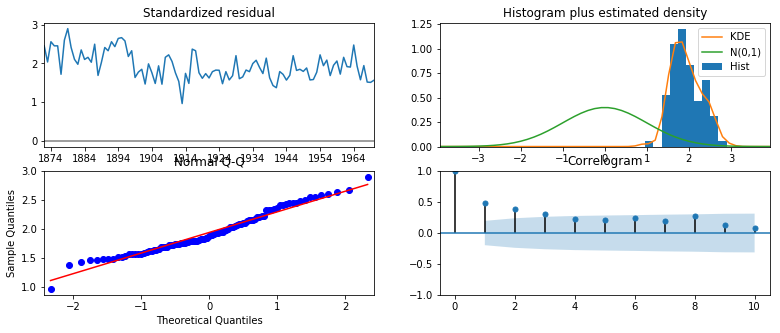

In [232]:
nile_results.plot_diagnostics(figsize=(13, 5));

## Passo a frente

In [239]:
# Usando o método filter temos as saídas completas do filtro de Kalman
nile_filtered_1 = nile_model_1.filter([15099.0, 1469.1])

print('Estados estimados via predição passo-a-frente:')
print(nile_filtered_1.filtered_state[0][:10]) 

Estados estimados via predição passo-a-frente:
[1103.34065938 1132.79163306 1067.99838143 1113.9817471  1127.61833521
 1136.76448161 1047.65510932 1097.14657445 1170.64987949 1162.42643459]


In [240]:
# Shape
nile.shape,nile_filtered_1.filtered_state[0].shape

((100,), (100,))

In [241]:
nile_filtered_1.filtered_state_cov.shape

(1, 1, 100)

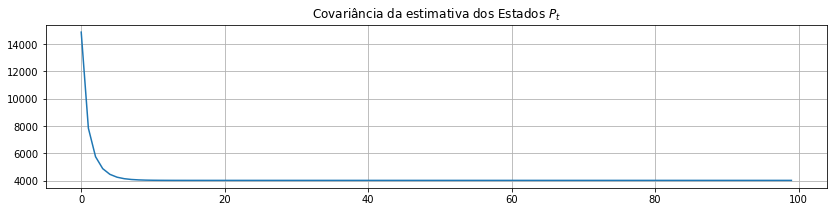

In [243]:
plt.figure(figsize=(14,3))
plt.plot(nile_filtered_1.filtered_state_cov[0, 0])
plt.title(r'Covariância da estimativa dos Estados $P_{t}$')
plt.grid()
plt.show()

In [59]:
#print(nile_filtered_1.filtered_state_cov[0, 0]) # [ 14874.41126432 ... 4032.15794181 ]

## Refinamento 

In [255]:
nile_smoothed_1 = nile_model_1.smooth([15099.0, 1469.1])

In [256]:
print('Estados refinados:')
print(nile_smoothed_1.smoothed_state[0][:10]) 

Estados refinados:
[1107.20389814 1107.58545838 1102.86719725 1111.75771149 1111.08946383
 1105.66232692 1094.9482521  1111.66713159 1116.87247926 1097.44906737]


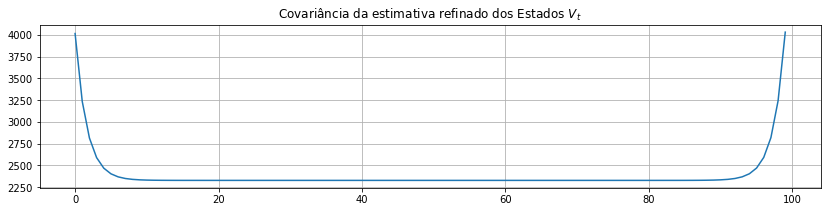

In [257]:
plt.figure(figsize=(14,3))
plt.plot(nile_smoothed_1.smoothed_state_cov[0, 0])
plt.title(r'Covariância da estimativa refinado dos Estados $V_{t}$')
plt.grid()
plt.show()

## Comparação $V_t$  e   $P_t$

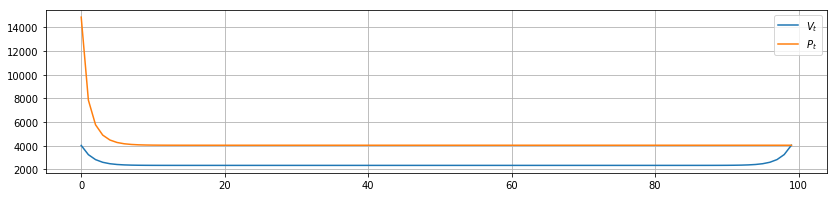

In [247]:
plt.figure(figsize=(14,3))
plt.plot(nile_smoothed_1.smoothed_state_cov[0, 0],label=r'$V_t$')
plt.plot(nile_filtered_1.filtered_state_cov[0, 0],label=r'$P_t$')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#print(nile_smoothed_1.smoothed_state_cov[0, 0])

## Plotando predições 

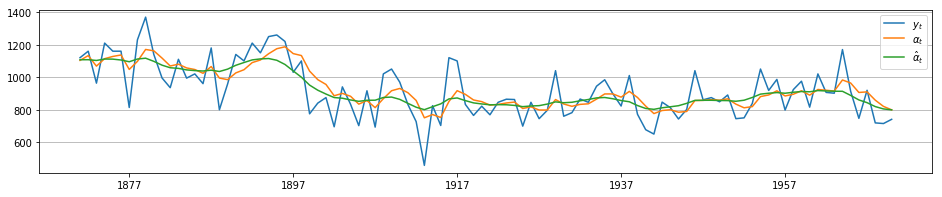

In [258]:
# Plot the series
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(nile.index.values,nile,label=r'$y_t$')
ax.plot(nile.index.values,nile_filtered_1.filtered_state[0],label=r'$\alpha_t$')
ax.plot(nile.index.values,nile_smoothed_1.smoothed_state[0],label=r'$\hat{\alpha}_t$')

ax.yaxis.grid()
ax.legend(loc='upper right', labelspacing=0.3);

In [254]:
from sklearn.metrics import mean_squared_error as mae
mae(nile,nile_smoothed_1.smoothed_state[0]),mae(nile,nile_filtered_1.filtered_state[0])

(12700.135411973684, 10916.783285843108)

# Local level via Classe `sm.tsa.UnobservedComponents` .

Unobserved Models tabém conhecidos como Modelos estruturais são os modelos que dividem explicitamente as componentes da série temporal em: tendência $\mu_t$, sazonalidade $\gamma_t$, cíclica $c_t$ e ruído $\varepsilon_t$

$$y_t = \mu_t +\gamma_t + c_t +\varepsilon_t$$

In [259]:
nile_model2 = sm.tsa.UnobservedComponents(nile, 'local level')
nile_results2 = nile_model2.fit()

print(nile_results2.summary())

                        Unobserved Components Results                         
Dep. Variable:                 volume   No. Observations:                  100
Model:                    local level   Log Likelihood                -632.538
Date:                Sun, 24 Jun 2018   AIC                           1269.076
Time:                        17:31:55   BIC                           1274.266
Sample:                    01-01-1871   HQIC                          1271.176
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.508e+04   2586.506      5.829      0.000       1e+04    2.01e+04
sigma2.level      1478.8115    851.329      1.737      0.082    -189.762    3147.385
Ljung-Box (Q):              

**Mesmos resultados porém os parâmetros são um pouco diferentes!**

Uma dos métodos da classe `UnobservedComponents` é o plot das componentes:

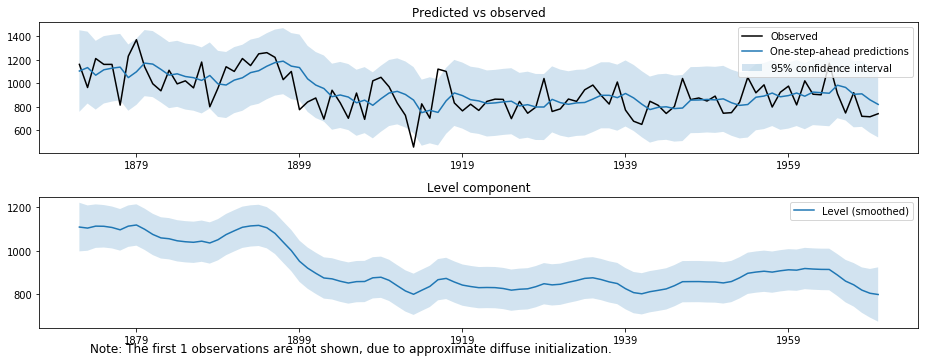

In [260]:
fig = nile_results2.plot_components(figsize=(13, 5))
fig.tight_layout()

# Curiosidades e métodos adicionais

1. Se o modelo for invariante no tempo, então será avaliado convergeência a cada iteração do filtro de Kalman. Uma vez esse critério tenha sido satisfeito, $P_t$, $K_t$ e $F_t$ são utilizados em todas as demais iterações. Existe um atributo denominado `tolerance` inicialmente configurado para $10^{-19}$ podendo ser ajustado. Para desabilitar essa estratégia basta setar por exemplo: `nile_model_3.tolerance = 0`

2. As duas estratégias para tratar vetores de saída de ordem elevadas (p>>>m), *univariate filtering* e *collapsible variables* podem ser ajustados pelo método `set_filter_method`. Por exemplo: `nile_model_3.set_filter_method(filter_univariate=True,filter_collapsed=True)`

3. Existem uma opção para otimizar o uso de memória RAM, que pode ser configura pelo método `set_conserve_memory`.

4. Predições e resposta ao impulso podem ser obtidas imediatamente pelo resultado obtido do método `filter`. Este objeto resultante possui os métodos `predict` e `impulse_response`.

5. O filtro de Kalman (e refinamento) já possuem rotinas para tratar dados faltantes.

6. Esta implementação da biblioteca não utiliza a versão Raiz-Quadrada do filtro de Kalman ($U_t^{\ast}$). Uma alternativa menos onerosa mencionada por Fulton é *enforced symmetry* podendo ser encontrada em Grewal and Andrews, 2014. 

7. As operações recursivas do filtro de Kalman são implementadas em Cython onde as operações são compilads em na linguagem C, aumentando drasticamente a performance. Para quando a performance for extremamente crítica (BLAS and LAPACK) 

8. É uma biblioteca open source mantida por uma comunidade. Já foram criados milhares de testes unitários para avaliar possíveis "bugs" na estrutra da biblioteca.

9. Por fim a extensiva capacidade de reproducibilidade, automação e separação de tarefas possibilitada pelo uso de POO.

Exemplo de [Local Linear Trend Model](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html)

# Referências 


- Chad, F (2017). Estimating time series models by state space methods in Python: Statsmodels.- 

- Grewal, M. and A. Andrews (2014, December). Kalman Filtering: Theory and Practice with MATLAB (4 edition ed.). Hoboken, New Jersey: Wiley-IEEE Press.
